In [1]:
"""
David Nnaji
4/12/2020
ENGR 571
Project 2
"""

#Libraries
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind,ttest_rel,ttest_ind_from_stats as ttifs
from itertools import combinations, combinations_with_replacement as cwr
from sklearn.metrics import confusion_matrix

In [2]:
#Gather all the data to one place (Source: http://mlr.cs.umass.edu/ml/machine-learning-databases/abalone/abalone.data)
names=[
	"Sex",
	"Length",
	"Diameter",
	"Height",
	"Whole",
	"Shucked",
	"Viscera",
	"Shell",
	"Rings"]
raw_data = pd.read_csv("abalone_data.csv",delimiter=",",names=names)

#Create a safe copy of the raw data to work with.
df = raw_data.copy()

#Remove Strange Data and Outlieres (Discovered while coding)
df = df[(df.Height<0.3)&(df.Height>0.0)]
df = df.drop(df.index[800:2100])
df = df.reset_index(drop=True)

#Create Age Column
df['Age'] = df['Rings']+1.5
names.append("Age")

#Create Coded Sex Column where (MFI = 123)
code = []
for i in df['Sex']:
    if i=="M":
        code.append(1)
    elif i=="F":
        code.append(2)
    elif i=="I":
        code.append(3)
    else:
        code.append(0)
df['Code_Sex']=code

#Define classes with new column 'Classes':
#x<4,5,...,20,x>21 ,where x is the no. of rings
df['Classes'] = df['Rings']
df.loc[df['Classes']<4,'Classes'],df.loc[df['Classes']>21,'Classes'] = 3,22
#df[(df['Rings']<4)|(df['Rings']>21)][:25] #View changes to specific groups

df

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings,Age,Code_Sex,Classes
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5,1,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5,1,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,10.5,2,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,11.5,1,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,8.5,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2868,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,12.5,2,11
2869,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5,1,10
2870,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5,1,9
2871,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5,2,10


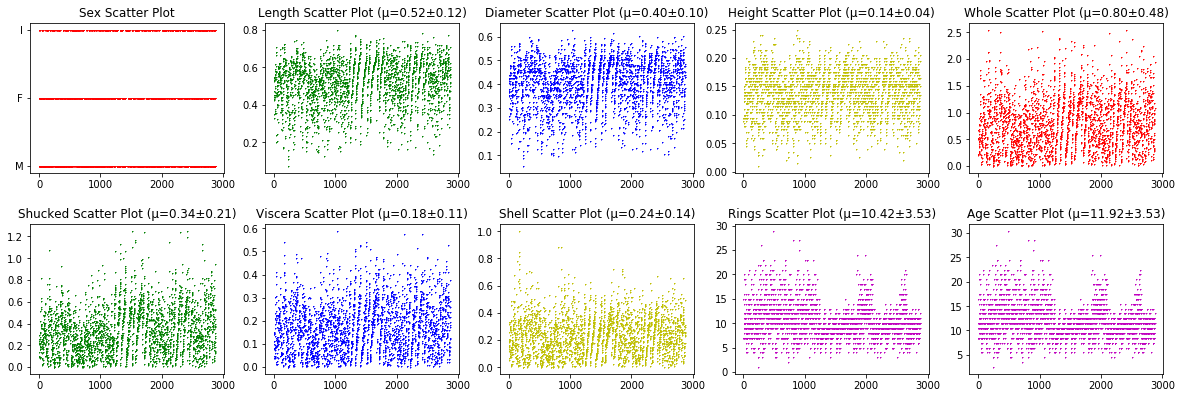

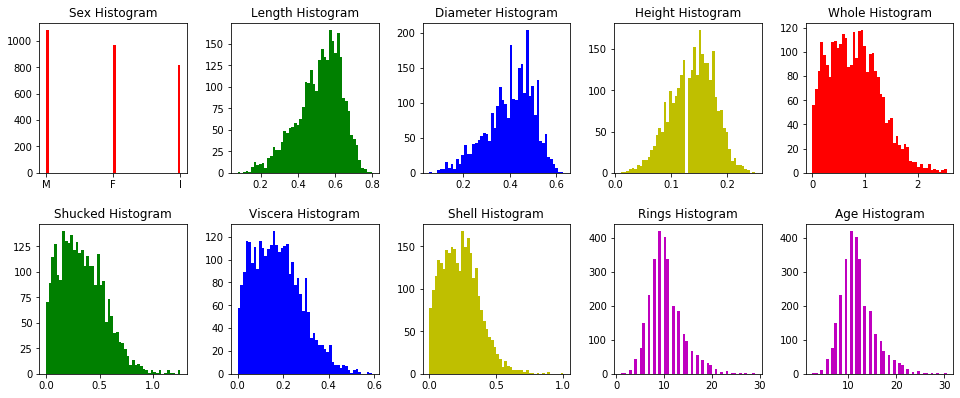

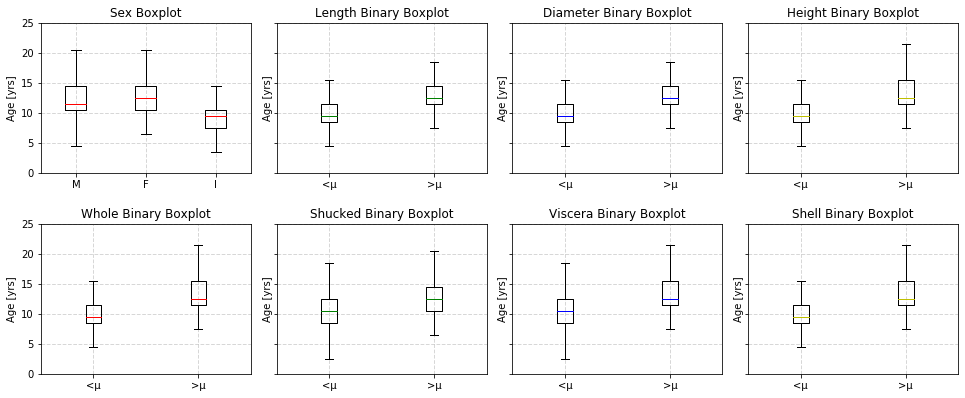

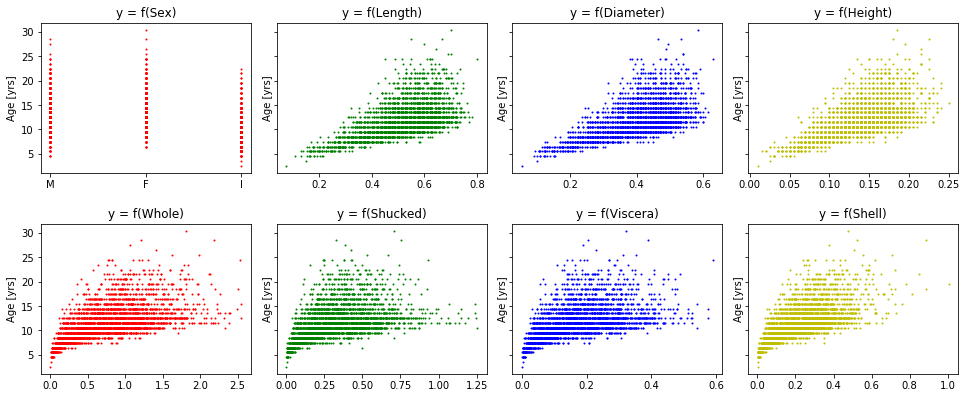

In [3]:
#Get the big picture! Broadly visulaize the data and explore relationships!

#Create scatter plots of all the factors
fig1, axes1 = plt.subplots(2, 5, figsize=(17, 6))
fig1.tight_layout(pad=3, w_pad=1, h_pad=3)
colors = 'rgbyrgbymm'
k=0
for i in range(2):
	for j in range(5):
		if names[k]=='Sex':
			axes1[i,j].plot(df[names[k]],'+',fillstyle='none',color=colors[k],markersize=1)
			axes1[i,j].set_title('{} Scatter Plot'.format(names[k]))
		else:
			axes1[i,j].plot(df[names[k]],'+',fillstyle='none',color=colors[k],markersize=1)
			axes1[i,j].set_title('{} Scatter Plot (μ={:.2f}±{:.2f})'.format(names[k],df[names[k]].mean(),df[names[k]].std()))
		k+=1
plt.savefig('Scatter_plots.png')

#Create histograms for all variables
fig2, axes2 = plt.subplots(2, 5, figsize=(14, 6))
fig2.tight_layout(pad=3, w_pad=1, h_pad=3)
k=0
for i in range(2):
	for j in range(5):
		axes2[i,j].hist(df[names[k]],bins=50,color=colors[k])
		axes2[i,j].set_title('{} Histogram'.format(names[k]))
		k+=1
plt.savefig('Histogram_plots.png')

#Scatter Plot Matrix
#g = sns.pairplot(df.loc[:, 'Length':'Rings'], plot_kws={"s": 5,"edgecolor":"none"}, height=1.25,aspect=1.75,diag_kind="kde")

#Box plots
fig3, axes3 = plt.subplots(2, 4, figsize=(14, 6),sharey=True)
fig3.tight_layout(pad=3, w_pad=1, h_pad=3)
k=0
for i in range(2):
    for j in range(4):
        if names[k]=='Sex':
            M_lst = df[df['Sex']=='M']['Age']
            F_lst = df[df['Sex']=='F']['Age']
            I_lst = df[df['Sex']=='I']['Age']
            axes3[i,j].boxplot([M_lst,F_lst,I_lst],labels=["M","F","I"],medianprops=dict(color=colors[k]),showfliers=False)
            axes3[i,j].set_title('{} Boxplot'.format(names[k]))
            axes3[i,j].grid(linestyle='--', linewidth=1,alpha=0.5)
            axes3[i,j].set_ylim(0,25)
            if ((i,j)==(0,0))|((i,j)==(0,1)):
                axes3[i,j].set_ylabel("Age [yrs]")
        else:
            l_mean = df[df[names[k]]<df[names[k]].mean()]['Age'].to_numpy()
            g_mean = df[df[names[k]]>df[names[k]].mean()]['Age'].to_numpy()
            axes3[i,j].boxplot([l_mean,g_mean],medianprops=dict(color=colors[k]),labels=["<μ",">μ"],showfliers=False)
            axes3[i,j].set_title('{} Binary Boxplot'.format(names[k]))
            axes3[i,j].grid(linestyle='--', linewidth=1,alpha=0.5)
            axes3[i,j].set_ylabel("Age [yrs]")
            if ((i,j)==(0,0))|((i,j)==(0,1)):
                axes3[i,j].set_ylabel("Age [yrs]")
        k+=1
plt.savefig('Box_plots.png')

#Graph factors vs response variable
fig4, axes4 = plt.subplots(2, 4, figsize=(14, 6),sharey=True)
fig4.tight_layout(pad=3, w_pad=1, h_pad=3)
k=0
for i in range(2):
    for j in range(4):
        axes4[i,j].plot(df[names[k]],df['Age'],'o',fillstyle='none',color=colors[k],markersize=1)
        axes4[i,j].set_title('y = f({})'.format(names[k]))
        axes4[i,j].set_ylabel("Age [yrs]")
        k+=1
plt.savefig('Facotors_vs_Response_plots.png')

#Show plots
plt.show()

In [4]:
results = ols('Rings ~ Code_Sex*Length*Diameter*Height*Whole*Shucked*Viscera*Shell', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     19.23
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        15:14:59   Log-Likelihood:                -6181.2
No. Observations:                2873   AIC:                         1.287e+04
Df Residuals:                    2617   BIC:                         1.440e+04
Df Model:                         255                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -13.6884     34.241     -0.400      0.689     -80.830      53.454
Code_Sex                                                        5.9626     11.938      0.499      0.618     -17.447      29.372
Length                                                       -110.7764    272.368     -0.407      0.684    -644.856     423.303
Code_Sex:Length                                                27.1829     99.529      0.273      0.785    -167.980     222.346
Diameter                                                      562.3202    432.159      1.301      0.193    -285.088    1409.728
Code_Sex:Diameter                                            -180.6945    157.677     -1.146      0.252    -489.878     128.489
Length:Diameter                                             -1013.7909   1381.838     -0.734      0.463   -3723.397    1695.815
Code_Sex:Length:Diameter                                      349.6347    503.146      0.695      0.487    -636.969    1336.239
Height                                                       -141.5833    516.440     -0.274      0.784   -1154.255     871.089
Code_Sex:Height                                               -15.9861    192.700     -0.083      0.934    -393.847     361.874
Length:Height                                                1135.5191   3432.420      0.331      0.741   -5595.013    7866.051
Code_Sex:Length:Height                                        199.6972   1361.256      0.147      0.883   -2469.550    2868.945
Diameter:Height                                             -3866.7524   5422.591     -0.713      0.476   -1.45e+04    6766.248
Code_Sex:Diameter:Height                                     1402.0764   2166.283      0.647      0.518   -2845.725    5649.878
Length:Diameter:Height                                       7286.4104   1.18e+04      0.618      0.537   -1.58e+04    3.04e+04
Code_Sex:Length:Diameter:Height                             -4361.0715   4964.670     -0.878      0.380   -1.41e+04    5374.006
Whole                                                         -74.3987   1291.906     -0.058      0.954   -2607.659    2458.862
Code_Sex:Whole                                                -38.7902    498.298     -0.078      0.938   -1015.888     938.308
Length:Whole                                                -7008.7880   6607.837     -1.061      0.289      -2e+04    5948.328
Code_Sex:Length:Whole                                        2910.5240   2779.976      1.047      0.295   -2540.649    8361.697
Diameter:Whole                                               1235.0106   7559.917      0.163      0.870   -1.36e+04    1.61e+04
Code_Sex:Di

In [5]:
test = results.pvalues
test.sort_values()[test<.001]

Code_Sex:Length:Height:Whole:Shucked             2.680286e-07
Length:Height:Whole:Shucked                      2.429850e-06
Height:Whole:Shucked                             6.602310e-06
Code_Sex:Height:Whole:Shucked                    8.513467e-06
Length:Diameter:Height:Shell                     6.254020e-05
Code_Sex:Length:Diameter:Shell                   9.741880e-05
Length:Diameter:Shell                            1.335319e-04
Code_Sex:Length:Diameter:Height:Shell            1.545369e-04
Length:Diameter:Height:Whole:Shucked             1.966677e-04
Code_Sex:Length:Whole:Shucked                    3.884938e-04
Code_Sex:Length:Diameter:Height:Whole:Shucked    5.160021e-04
Code_Sex:Diameter:Height:Viscera:Shell           9.308430e-04
dtype: float64

In [6]:
results2 = ols('Classes ~ Code_Sex*Length*Diameter*Height*Whole*Shucked*Viscera*Shell', data=df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Classes   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     19.26
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        15:15:00   Log-Likelihood:                -6137.0
No. Observations:                2873   AIC:                         1.279e+04
Df Residuals:                    2617   BIC:                         1.431e+04
Df Model:                         255                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -12.8608     33.718     -0.381      0.703     -78.977      53.255
Code_Sex                                                        7.3456     11.756      0.625      0.532     -15.706      30.398
Length                                                       -107.5864    268.207     -0.401      0.688    -633.505     418.333
Code_Sex:Length                                                21.1925     98.008      0.216      0.829    -170.988     213.373
Diameter                                                      529.9432    425.556      1.245      0.213    -304.517    1364.403
Code_Sex:Diameter                                            -185.5921    155.268     -1.195      0.232    -490.052     118.868
Length:Diameter                                              -904.7640   1360.725     -0.665      0.506   -3572.970    1763.442
Code_Sex:Length:Diameter                                      358.0047    495.458      0.723      0.470    -613.525    1329.534
Height                                                        -93.2925    508.549     -0.183      0.854   -1090.492     903.907
Code_Sex:Height                                               -58.8526    189.756     -0.310      0.756    -430.940     313.235
Length:Height                                                 736.5902   3379.976      0.218      0.828   -5891.106    7364.286
Code_Sex:Length:Height                                        421.1241   1340.457      0.314      0.753   -2207.340    3049.588
Diameter:Height                                             -3628.4636   5339.738     -0.680      0.497   -1.41e+04    6842.074
Code_Sex:Diameter:Height                                     1551.7606   2133.184      0.727      0.467   -2631.138    5734.659
Length:Diameter:Height                                       7273.4945   1.16e+04      0.626      0.531   -1.55e+04       3e+04
Code_Sex:Length:Diameter:Height                             -5059.3138   4888.814     -1.035      0.301   -1.46e+04    4527.020
Whole                                                         -56.4230   1272.167     -0.044      0.965   -2550.978    2438.132
Code_Sex:Whole                                                -32.5271    490.684     -0.066      0.947    -994.696     929.642
Length:Whole                                                -6883.3775   6506.875     -1.058      0.290   -1.96e+04    5875.765
Code_Sex:Length:Whole                                        3020.6163   2737.500      1.103      0.270   -2347.268    8388.500
Diameter:Whole                                                537.6989   7444.408      0.072      0.942   -1.41e+04    1.51e+04
Code_Sex:Di

In [7]:
#Split data into training (70%) and testing (30%) factors and output arrays
x_train, x_test = tts(df, test_size=0.30, random_state=35)

In [8]:
x_train.groupby('Classes').mean()

,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings,Age,Code_Sex
Classes,,,,,,,,,,
3,0.164583,0.117500,0.036667,0.022292,0.008458,0.005292,0.007625,2.750000,4.250000,2.500000
4,0.215857,0.158571,0.053000,0.053529,0.022557,0.011771,0.015543,4.000000,5.500000,2.714286
5,0.268019,0.198208,0.064434,0.099972,0.050255,0.022623,0.030557,5.000000,6.500000,2.698113
6,0.353416,0.265347,0.088416,0.232673,0.102515,0.051426,0.068347,6.000000,7.500000,2.693069
7,0.410184,0.312147,0.103313,0.373718,0.169365,0.079871,0.106647,7.000000,8.500000,2.368098
8,0.482013,0.372124,0.122987,0.592150,0.267889,0.129575,0.166569,8.000000,9.500000,2.190265
9,0.533007,0.414319,0.139053,0.803643,0.360033,0.181123,0.224937,9.000000,10.500000,1.784053
10,0.557898,0.436420,0.150038,0.941992,0.416559,0.208883,0.265074,10.000000,11.500000,1.659091
11,0.585418,0.459435,0.157594,1.068559,0.467126,0.237257,0.305253,11.000000,12.500000,1.686192


In [9]:
x_test

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings,Age,Code_Sex,Classes
1592,I,0.540,0.415,0.110,0.6190,0.2755,0.1500,0.1765,10,11.5,3,10
539,F,0.375,0.290,0.115,0.2705,0.0930,0.0660,0.0885,10,11.5,2,10
324,M,0.335,0.265,0.105,0.2220,0.0935,0.0560,0.0750,7,8.5,1,7
902,I,0.275,0.220,0.080,0.1365,0.0565,0.0285,0.0420,6,7.5,3,6
2871,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...
2865,M,0.520,0.385,0.165,0.7910,0.3750,0.1800,0.1815,10,11.5,1,10
1761,M,0.635,0.500,0.180,1.1540,0.4405,0.2315,0.3870,9,10.5,1,9
929,F,0.560,0.445,0.180,0.9030,0.3575,0.2045,0.2950,9,10.5,2,9
1340,I,0.485,0.375,0.130,0.5535,0.2660,0.1120,0.1570,8,9.5,3,8


In [10]:
#Confirm percentages and see size
print(x_train.shape[0]/(x_train.shape[0]+x_test.shape[0]),x_test.shape[0]/(x_train.shape[0]+x_test.shape[0]))
print(x_train.shape[0],x_test.shape[0])

0.6999651931778629 0.3000348068221371
2011 862


In [11]:
#Compare Training and Testing sets to ensure populations are the sufficiently similar
print("FACTOR: tval, pval, tval<1.330")
for i in names[1:-1]:
    tval,pval =ttest_ind(x_test[i],x_train[i])
    print("{}: {:.3f}, {:.3f}, {}".format(i,tval,pval,tval<1.333))

FACTOR: tval, pval, tval<1.330
Length: 0.311, 0.756, True
Diameter: 0.407, 0.684, True
Height: -0.123, 0.902, True
Whole: -0.708, 0.479, True
Shucked: -0.528, 0.598, True
Viscera: -0.742, 0.458, True
Shell: -0.948, 0.343, True
Rings: -0.905, 0.365, True


In [12]:
#Create Feature Classification Table (Feature Frame) from training set
feature_names = {'Length':'L','Diameter':'D','Height':'H','Whole':'W','Shucked':'Sk','Viscera':'V','Shell':'Sl','Code_Sex':'CS'}
x_train = x_train.rename(columns=feature_names)
x_train = x_train[["Classes","Rings","Age","Sex"]+list(feature_names.values())]

feats=[]
for i in range(2,9):
    feats+=list(combinations(feature_names.values(),i))

for i in feats:
    #O2-O8 Multiplicative Derived Features
    if len(i)==2:
        x_train[i[0]+"*"+i[1]]=x_train[i[0]]*x_train[i[1]]
    elif len(i)==3:
        x_train[i[0]+"*"+i[1]+"*"+i[2]]=x_train[i[0]]*x_train[i[1]]*x_train[i[2]]
    elif len(i)==4:
        x_train[i[0]+"*"+i[1]+"*"+i[2]+"*"+i[3]]=x_train[i[0]]*x_train[i[1]]*x_train[i[2]]*x_train[i[3]]
    elif len(i)==5:
        x_train[i[0]+"*"+i[1]+"*"+i[2]+"*"+i[3]+"*"+i[4]]=x_train[i[0]]*x_train[i[1]]*x_train[i[2]]*x_train[i[3]]*x_train[i[4]]
    elif len(i)==6:
        x_train[i[0]+"*"+i[1]+"*"+i[2]+"*"+i[3]+"*"+i[4]+"*"+i[5]]=x_train[i[0]]*x_train[i[1]]*x_train[i[2]]*x_train[i[3]]*x_train[i[4]]*x_train[i[5]]
    elif len(i)==7:
        x_train[i[0]+"*"+i[1]+"*"+i[2]+"*"+i[3]+"*"+i[4]+"*"+i[5]+"*"+i[6]]=x_train[i[0]]*x_train[i[1]]*x_train[i[2]]*x_train[i[3]]*x_train[i[4]]*x_train[i[5]]*x_train[i[6]]
    else:
        x_train[i[0]+"*"+i[1]+"*"+i[2]+"*"+i[3]+"*"+i[4]+"*"+i[5]+"*"+i[6]+"*"+i[7]]=x_train[i[0]]*x_train[i[1]]*x_train[i[2]]*x_train[i[3]]*x_train[i[4]]*x_train[i[5]]*x_train[i[6]]*x_train[i[7]]

for i in feats:
    #O2 Divisive Derived Features
    if len(i)==2:
        x_train[i[0]+"/"+i[1]]=x_train[i[0]]/x_train[i[1]]

"""       
O2 Hybrid Derived features
Hybrid 1: CS + (W/Sl)+(L/H)
Hybrid 2: (W/Sl)+(L/H)
Hybrid 3: (H/W)+(Sk/W)
Hybrid 4: [(L/H)+(D/H)]/[(W/Sk)+(W/V)+(W/Sl)]
"""
x_train['H1'] = x_train['CS'] + (x_train['W']/x_train['Sl'])+(x_train['L']/x_train['H'])
x_train['H2'] = (x_train['W']/x_train['Sl'])+(x_train['L']/x_train['H'])
x_train['H3'] = (x_train['H']/x_train['W'])+(x_train['Sk']/x_train['W'])
x_train['H4'] = ((x_train['L']/x_train['H'])+(x_train['D']/x_train['H']))/((x_train['W']/x_train['Sk'])+(x_train['W']/x_train['V'])+(x_train['W']/x_train['Sl']))

x_train #.iloc[:,50:80]

,Classes,Rings,Age,Sex,L,D,H,W,Sk,V,...,Sk/V,Sk/Sl,Sk/CS,V/Sl,V/CS,Sl/CS,H1,H2,H3,H4
2777,11,11,12.5,M,0.560,0.450,0.145,0.9355,0.4250,0.1645,...,2.583587,1.559633,0.425000,0.603670,0.16450,0.27250,8.295096,7.295096,0.609300,0.615267
2011,11,11,12.5,I,0.450,0.355,0.115,0.4385,0.1840,0.1080,...,1.703704,1.635556,0.061333,0.960000,0.03600,0.03750,10.810821,7.810821,0.681870,0.676910
1910,13,13,14.5,F,0.555,0.420,0.140,0.8680,0.3300,0.2430,...,1.358025,1.571429,0.165000,1.157143,0.12150,0.10500,10.097619,8.097619,0.541475,0.673812
385,9,9,10.5,F,0.455,0.370,0.105,0.4925,0.2160,0.1245,...,1.734940,1.600000,0.108000,0.922222,0.06225,0.06750,9.981481,7.981481,0.651777,0.794930
848,18,18,19.5,F,0.745,0.585,0.190,1.9660,0.8435,0.4370,...,1.930206,1.440649,0.421750,0.746371,0.21850,0.29275,9.278866,7.278866,0.525687,0.687121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,8,8,9.5,M,0.485,0.365,0.155,1.0290,0.4235,0.2285,...,1.853392,1.353035,0.423500,0.730032,0.22850,0.31300,7.416572,6.416572,0.562196,0.536552
2792,12,12,13.5,F,0.635,0.500,0.175,1.4770,0.6840,0.3005,...,2.276206,1.753846,0.342000,0.770513,0.15025,0.19500,9.415751,7.415751,0.581584,0.597119
951,14,14,15.5,M,0.650,0.495,0.180,1.7930,0.8005,0.3390,...,2.361357,1.510377,0.800500,0.639623,0.33900,0.53000,7.994130,6.994130,0.546849,0.582949
1295,9,9,10.5,M,0.600,0.460,0.150,1.2470,0.5335,0.2735,...,1.950640,1.839655,0.533500,0.943103,0.27350,0.29000,9.300000,8.300000,0.548115,0.631132


In [13]:
#Determine the best features for classification
nclasses = x_train.groupby('Classes').mean().index.size
grand_cpts_rank, grand_pval_rank, grand_tval_rank= [],[],[]
grand_cpts_dict = {} #Used later for determining weights. Only Cpts vals were saved to preserve memory but p and t can alo be saved.
for i in x_train.columns.to_list()[4:]:
    #test = x_train.groupby('Classes').mean()[i].sort_values() #For Debugging
    ranked_means = x_train.groupby("Classes").mean()[i].sort_values().to_list() 
    class_order = x_train.groupby("Classes").mean()[i].sort_values().index
    ranked_stds = x_train.groupby("Classes").std()[i].loc[class_order].to_list()
    ranked_nobs = x_train.groupby("Classes").count()[i].loc[class_order].to_list()
    ranked_cpts,ranked_pvals,ranked_tvals= [],[],[]
    
    for j in range(nclasses-1):
        m1 = ranked_means[j]
        m2 = ranked_means[j+1]
        s1 = ranked_stds[j]
        s2 = ranked_stds[j+1]
        n1 = ranked_nobs[j]
        n2 = ranked_nobs[j+1]
        nstd_CPt = (m2-m1)/(s1+s2)
        CPt = m1+nstd_CPt*s1
        assert round(CPt,3) == round(m2-nstd_CPt*s2,3) #math check
        ranked_cpts.append(CPt)
        tval,pval = ttifs(m1,s1,n1,m2,s2,n2,True)
        ranked_pvals.append(pval)
        ranked_tvals.append(tval)
        
    grand_cpts_dict[i]=ranked_cpts
    grand_cpts_rank.append(sum(ranked_cpts))
    grand_pval_rank.append(sum(ranked_pvals))
    grand_tval_rank.append(sum(ranked_tvals))

assert len(x_train.columns.to_list()[4:]) == len(grand_cpts_rank)
assert len(x_train.columns.to_list()[4:]) == len(grand_pval_rank)

In [14]:
#Observe Reults and pick top 8 features
training_results = pd.DataFrame(x_train.columns.to_list()[4:],columns=['Features'])
training_results['nSTD-Cpts'] = grand_cpts_rank
training_results['p'] = grand_pval_rank
training_results['t'] = grand_tval_rank
training_results=training_results.set_index('Features')
training_results

,nSTD-Cpts,p,t
Features,,,
L,9.661953,8.858040,-45.434463
D,7.560951,8.380614,-46.728629
H,2.662974,7.412712,-45.729928
W,16.055939,8.277295,-44.867507
Sk,6.342276,10.363341,-33.194192
...,...,...,...
Sl/CS,3.542994,8.046013,-38.557244
H1,169.871275,10.148371,-19.586718
H2,133.756239,10.933558,-13.506284


In [15]:
training_results.sort_values('nSTD-Cpts',0,False)[:8]

,nSTD-Cpts,p,t
Features,,,
H1,169.871275,10.148371,-19.586718
H2,133.756239,10.933558,-13.506284
L/V,124.641953,10.443273,-30.089511
D/V,93.679837,10.705593,-29.453491
W/V,91.797481,13.116778,-8.394378
L/Sl,79.393247,6.789942,-48.131532
L/H,71.860856,10.750272,-15.254836
L/Sk,61.832010,9.872302,-33.489670


In [16]:
training_results.sort_values('p')[:8]

,nSTD-Cpts,p,t
Features,,,
H3,13.745092,5.702444,-44.040860
D/Sl,59.561624,6.696112,-48.102531
L/Sl,79.393247,6.789942,-48.131532
Sl,5.046722,7.032526,-50.240498
H/Sl,19.846747,7.052305,-42.117822
H*Sl,0.854099,7.208598,-47.444898
L*Sl,3.019811,7.243114,-47.337961
D*Sl,2.388435,7.301768,-47.431891


In [17]:
training_results.sort_values('t',0,False)[:8]

,nSTD-Cpts,p,t
Features,,,
V/Sl,13.342850,13.295353,-7.853340
W/V,91.797481,13.116778,-8.394378
Sk/V,36.943882,12.766208,-8.706416
W/Sl,61.764970,12.798348,-8.747729
Sk/Sl,24.929082,12.132594,-10.082187
D/H,55.633326,12.931733,-10.120903
L*CS,17.313037,14.177818,-10.323048
D*CS,13.488930,14.368906,-10.948866


In [18]:
#Looks like the metric don't think the same features are the best
rg = 8
setA = set(training_results.sort_values('nSTD-Cpts',0,False)[:rg].index)
setB = training_results.sort_values('p')[:rg].index
setC = training_results.sort_values('t')[:rg].index
intersecting_features = setA.intersection(setB) #AC,36,AB,46,BC,15
intersecting_features

{'L/Sl'}

In [19]:
top_Cpts_features = training_results.sort_values('nSTD-Cpts',0,False)[:8].index
top_p_features = training_results.sort_values('p')[:8].index
top_t_features = training_results.sort_values('t',0,False)[:8].index

#I select *drum roll* nSTD-Cpts! At least for now. More testing required to quantitaviely know.
selected_features = training_results.loc[top_Cpts_features]
selected_features

,nSTD-Cpts,p,t
Features,,,
H1,169.871275,10.148371,-19.586718
H2,133.756239,10.933558,-13.506284
L/V,124.641953,10.443273,-30.089511
D/V,93.679837,10.705593,-29.453491
W/V,91.797481,13.116778,-8.394378
L/Sl,79.393247,6.789942,-48.131532
L/H,71.860856,10.750272,-15.254836
L/Sk,61.832010,9.872302,-33.489670


In [20]:
#Obtain weights
weights_table = pd.DataFrame.from_dict(grand_cpts_dict)[selected_features.index]
deployed_weights = ((weights_table**2).sum())/((weights_table**2).sum().sum())
deployed_weights

H1      0.190838
H2      0.117821
L/V     0.290070
D/V     0.155789
W/V     0.055505
L/Sl    0.098063
L/H     0.034137
L/Sk    0.057777
dtype: float64

In [21]:
#Testing!
feature_names = {'Length':'L','Diameter':'D','Height':'H','Whole':'W','Shucked':'Sk','Viscera':'V','Shell':'Sl','Code_Sex':'CS'}
x_test = x_test.rename(columns=feature_names)
x_test = x_test[["Classes","Rings","Age","Sex"]+list(feature_names.values())]

In [22]:
#This code will change depending on deployed features
x_test['H1'] = x_test['CS'] + (x_test['W']/x_test['Sl'])+(x_test['L']/x_test['H'])
x_test['H2'] = (x_test['W']/x_test['Sl'])+(x_test['L']/x_test['H'])
for j in deployed_weights.index[2:]:
    i = j.split("/")
    if len(i)==2:
        x_test[i[0]+"/"+i[1]]=x_test[i[0]]/x_test[i[1]]
        
x_test[deployed_weights.index].shape

(862, 8)

In [23]:
#Compute z-Value for each Sample’s Features
def zscore(S,m1,s1,n1):
    return (abs(S-m1)*sqrt(n1))/s1

test_means = x_train[['Classes']+list(deployed_weights.index)].groupby('Classes').mean()
test_stds = x_train[['Classes']+list(deployed_weights.index)].groupby('Classes').std()
test_nobs = x_train[['Classes']+list(deployed_weights.index)].groupby('Classes').count()

In [24]:
test_means[:10]

,H1,H2,L/V,D/V,W/V,L/Sl,L/H,L/Sk
Classes,,,,,,,,
3,10.376637,7.876637,43.214968,31.142305,4.317182,26.215079,4.912563,25.826115
4,10.749360,8.035074,36.429515,27.055179,8.244100,17.468657,4.484647,12.657168
5,10.272851,7.574738,15.334637,11.256438,4.602422,10.659258,4.314407,8.406614
6,10.154762,7.461693,8.442530,6.302586,4.614691,6.140005,4.040604,4.390676
7,9.782869,7.414771,6.966488,5.266183,4.812132,4.702837,4.008410,3.391264
8,9.647419,7.457153,4.849400,3.704308,4.683096,3.477362,3.972963,2.433256
9,9.177449,7.393396,3.648191,2.824828,4.515928,2.763047,3.877169,1.932084
10,8.945288,7.286197,3.304455,2.574107,4.576117,2.450313,3.768761,1.709924
11,8.882616,7.196423,2.954419,2.313364,4.557229,2.171825,3.757594,1.585507


In [124]:
#Get z-table
cray=[]
for f in x_test[deployed_weights.index]:
    rows = []
    for v in x_test[f]:
        vals=[]
        for m,s,n in zip(test_means[f],test_stds[f],test_nobs[f]):
            vals.append(zscore(v,m,s,n))
        rows.append(vals)

    cray.append(pd.DataFrame(np.array(rows)))

for i in range(len(cray)):
    new={}
    Flabel = deployed_weights.index[i]
    for j in range(len(test_stds.index)):
        Clabel = test_means.index[j]
        new[j] = "z({})c{}".format(Flabel,Clabel)
    cray[i] = cray[i].rename(columns=new)

#Define f(z), Compute f(z) for each Sample’s Features
def fz(table):
    return (1/(table**2))

#normalize
for i in range(len(cray)):
    cray[i] =( (fz(cray[i]).transpose())/(fz(cray[i]).sum(axis=1))).transpose()


z_table = pd.concat(cray, axis=1)
z_table

,z(H1)c3,z(H1)c4,z(H1)c5,z(H1)c6,z(H1)c7,z(H1)c8,z(H1)c9,z(H1)c10,z(H1)c11,z(H1)c12,...,z(L/Sk)c13,z(L/Sk)c14,z(L/Sk)c15,z(L/Sk)c16,z(L/Sk)c17,z(L/Sk)c18,z(L/Sk)c19,z(L/Sk)c20,z(L/Sk)c21,z(L/Sk)c22
0,0.481739,0.417437,0.037121,0.011494,0.004269,0.002263,0.000876,0.000880,0.000739,0.001117,...,0.008466,0.011526,0.005259,0.007806,0.003870,0.009146,0.017185,0.004039,0.005765,0.036111
1,0.004107,0.001050,0.000425,0.000181,0.000177,0.000134,0.000198,0.000456,0.000496,0.003095,...,0.001107,0.001393,0.001150,0.001618,0.001323,0.002892,0.005461,0.001796,0.002301,0.009731
2,0.089895,0.025756,0.008945,0.003642,0.002954,0.002041,0.001920,0.002997,0.002840,0.007207,...,0.001241,0.001565,0.001266,0.001784,0.001427,0.003132,0.005914,0.001912,0.002464,0.010618
3,0.148435,0.022291,0.019177,0.011342,0.169547,0.596751,0.002284,0.001321,0.000991,0.001043,...,0.000957,0.001202,0.001015,0.001424,0.001194,0.002598,0.004908,0.001647,0.002096,0.008671
4,0.414972,0.049578,0.060827,0.045356,0.359323,0.031493,0.001946,0.001331,0.001029,0.001185,...,0.012456,0.014841,0.020939,0.027649,0.049035,0.091647,0.174729,0.136125,0.124530,0.234847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,0.000266,0.000066,0.000028,0.000012,0.000013,0.000010,0.000018,0.000050,0.000061,0.001184,...,0.000684,0.000791,0.001609,0.002017,0.009348,0.013331,0.025797,0.852506,0.065940,0.023818
858,0.046282,0.012923,0.004644,0.001910,0.001610,0.001132,0.001153,0.001905,0.001838,0.005124,...,0.000188,0.000213,0.000543,0.000656,0.009012,0.008370,0.016524,0.013024,0.940318,0.010050
859,0.000824,0.000215,0.000085,0.000036,0.000034,0.000025,0.000033,0.000069,0.000072,0.000328,...,0.001796,0.001867,0.034983,0.025400,0.005658,0.022740,0.041079,0.001985,0.004072,0.791098
860,0.167342,0.003556,0.819965,0.008273,0.000237,0.000089,0.000018,0.000015,0.000012,0.000015,...,0.058332,0.087267,0.022749,0.035119,0.012849,0.031597,0.059216,0.011910,0.017800,0.136437


In [125]:
#Apply weights
j=0
for i in range(z_table.shape[1]):
    z_table[z_table.columns[i]] = z_table[z_table.columns[i]]*deployed_weights[j]
    if j==len(deployed_weights)-1:
        j=0
    else:
        j+=1
z_table

,z(H1)c3,z(H1)c4,z(H1)c5,z(H1)c6,z(H1)c7,z(H1)c8,z(H1)c9,z(H1)c10,z(H1)c11,z(H1)c12,...,z(L/Sk)c13,z(L/Sk)c14,z(L/Sk)c15,z(L/Sk)c16,z(L/Sk)c17,z(L/Sk)c18,z(L/Sk)c19,z(L/Sk)c20,z(L/Sk)c21,z(L/Sk)c22
0,0.091934,0.049183,0.010768,0.001791,2.369445e-04,2.219183e-04,2.989237e-05,5.083823e-05,0.000141,0.000132,...,0.000289,0.000666,0.001004,0.000920,0.001123,0.001425,0.000954,0.000396,0.000197,0.002086
1,0.000784,0.000124,0.000123,0.000028,9.846054e-06,1.312942e-05,6.775405e-06,2.633537e-05,0.000095,0.000365,...,0.000038,0.000081,0.000220,0.000191,0.000384,0.000450,0.000303,0.000176,0.000079,0.000562
2,0.017155,0.003035,0.002595,0.000567,1.639451e-04,2.001383e-04,6.553665e-05,1.731716e-04,0.000542,0.000849,...,0.000042,0.000090,0.000242,0.000210,0.000414,0.000488,0.000328,0.000187,0.000084,0.000613
3,0.028327,0.002626,0.005563,0.001767,9.410710e-03,5.851926e-02,7.798130e-05,7.629486e-05,0.000189,0.000123,...,0.000033,0.000069,0.000194,0.000168,0.000346,0.000405,0.000272,0.000162,0.000072,0.000501
4,0.079192,0.005841,0.017644,0.007066,1.994427e-02,3.088257e-03,6.644639e-05,7.689328e-05,0.000196,0.000140,...,0.000425,0.000857,0.003996,0.003258,0.014224,0.014278,0.009698,0.013349,0.004251,0.013569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,0.000051,0.000008,0.000008,0.000002,6.953320e-07,9.563949e-07,5.990758e-07,2.916425e-06,0.000012,0.000139,...,0.000023,0.000046,0.000307,0.000238,0.002712,0.002077,0.001432,0.083599,0.002251,0.001376
858,0.008832,0.001523,0.001347,0.000298,8.938775e-05,1.110165e-04,3.936035e-05,1.100511e-04,0.000351,0.000604,...,0.000006,0.000012,0.000104,0.000077,0.002614,0.001304,0.000917,0.001277,0.032100,0.000581
859,0.000157,0.000025,0.000025,0.000006,1.873484e-06,2.452978e-06,1.139914e-06,3.992798e-06,0.000014,0.000039,...,0.000061,0.000108,0.006676,0.002993,0.001641,0.003543,0.002280,0.000195,0.000139,0.045707
860,0.031935,0.000419,0.237847,0.001289,1.314201e-05,8.726413e-06,5.997616e-07,8.414235e-07,0.000002,0.000002,...,0.001991,0.005042,0.004341,0.004138,0.003727,0.004922,0.003287,0.001168,0.000608,0.007883


In [126]:
#Lets get the results!
results = pd.DataFrame()
for i in range(20):
    results[str(i+3)]=z_table[z_table.columns[i::20]].sum(axis=1).to_list()
results

,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.432563,0.139150,0.022290,0.005796,0.009246,0.033485,0.489839,0.019599,0.002879,0.009884,0.006923,0.005083,0.007508,0.006050,0.007609,0.013950,0.011705,0.005165,0.018026,0.011303
1,0.159806,0.135882,0.025481,0.057806,0.158423,0.029425,0.004584,0.002211,0.001644,0.002831,0.006257,0.019272,0.004361,0.012104,0.009638,0.043329,0.025440,0.091456,0.046253,0.101314
2,0.138636,0.149543,0.028667,0.022770,0.380145,0.012204,0.002520,0.001688,0.002012,0.003355,0.008356,0.007835,0.005703,0.014988,0.013185,0.021154,0.033056,0.047907,0.110834,0.129750
3,0.087624,0.128749,0.046520,0.124582,0.040321,0.060582,0.000772,0.000483,0.000583,0.001276,0.004424,0.003549,0.001332,0.041143,0.287677,0.021175,0.042150,0.034587,0.011080,0.033530
4,0.312292,0.076265,0.124549,0.021226,0.022374,0.005693,0.002839,0.003085,0.003988,0.003357,0.041554,0.006094,0.010448,0.011132,0.030588,0.032211,0.068026,0.035017,0.068058,0.056951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,0.177096,0.018705,0.030465,0.018581,0.007459,0.013929,0.195810,0.007380,0.004220,0.003355,0.007041,0.008714,0.060174,0.008607,0.020371,0.057599,0.038013,0.143999,0.039349,0.066785
858,0.011504,0.014015,0.005017,0.001053,0.000843,0.000368,0.000177,0.000282,0.000584,0.001059,0.003287,0.003292,0.002506,0.034181,0.076019,0.044975,0.107333,0.025189,0.165100,0.244951
859,0.152642,0.020393,0.023787,0.004043,0.000667,0.000810,0.001237,0.001448,0.006293,0.003147,0.007063,0.020862,0.061335,0.065506,0.025075,0.035032,0.110002,0.038550,0.061262,0.321517
860,0.076630,0.075654,0.250161,0.009421,0.019025,0.082079,0.088889,0.117941,0.048542,0.046894,0.023791,0.012264,0.017211,0.010986,0.047009,0.019620,0.020253,0.008358,0.071149,0.024683


In [127]:
#BOOM BABY!
results.idxmax(axis=1) #for index locations
#results.max(axis=1) #for values

0       9
1       3
2       7
3      17
4       3
       ..
857     9
858    22
859    22
860     5
861    22
Length: 862, dtype: object

In [128]:
#Compare to actual answers (i.e. compute accuracy)
comparison = pd.DataFrame([int(i) for i in results.idxmax(axis=1).to_list()],columns=['Classification'])
comparison['Actual'] = x_test['Classes'].to_list()
comparison

,Classification,Actual
0,9,10
1,3,10
2,7,7
3,17,6
4,3,10
...,...,...
857,9,10
858,22,9
859,22,9
860,5,8


In [129]:
F = (comparison['Classification']==comparison['Actual']).value_counts()[0]
T = (comparison['Classification']==comparison['Actual']).value_counts()[1]
accuracy = T/(T+F)
accuracy

0.08700696055684455

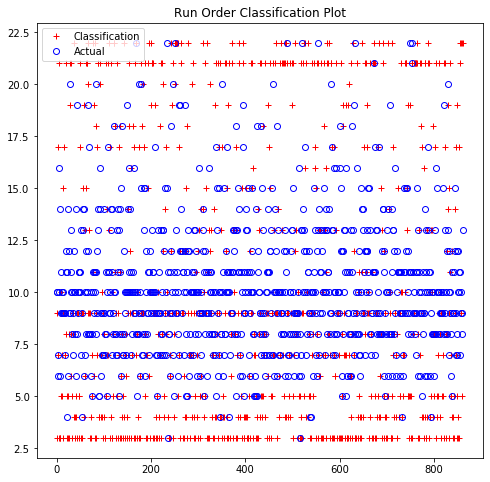

In [130]:
fig5, axes5 = plt.subplots(1,1,figsize=(8,8))
axes5 = plt.plot(comparison['Classification'].to_list(),'+r',label='Classification')
axes5 = plt.plot(comparison['Actual'].to_list(),'ob',label='Actual',fillstyle='none')
plt.title("Run Order Classification Plot")
plt.legend(fontsize=10)
plt.savefig('Classification_Scatter_Plot.png')
plt.show()

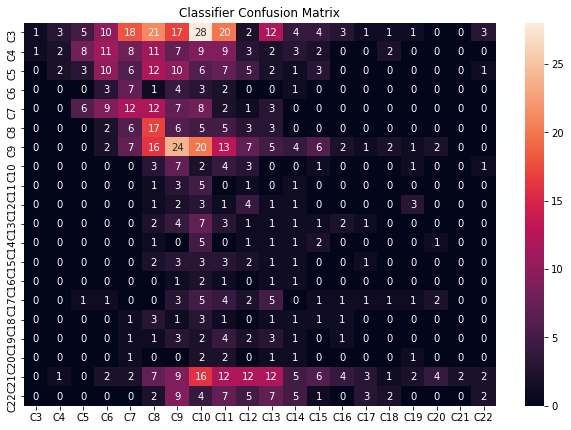

In [131]:
#Confusion Matrix
CM = confusion_matrix(comparison['Classification'],comparison['Actual'])

df_CM = pd.DataFrame(CM, ['C'+str(i) for i in range(3,23)],columns=['C'+str(i) for i in range(3,23)])
fig6, axes6 = plt.subplots(1,1,figsize=(10,7))
fig6.tight_layout(pad=5, w_pad=1, h_pad=3)
ax6 = sns.heatmap(df_CM,annot=True)
axes6.set_ylim(20,0)
axes6.set_title('Classifier Confusion Matrix')
plt.savefig('Classifier_Confusion_Matrix.png')
plt.show()

In [170]:
(pd.Series(np.diag(df_CM), index=[df_CM.index, df_CM.columns]).to_numpy()/df_CM.sum().to_numpy())


mdg = pd.Series(np.diag(df_CM), index=[df_CM.index, df_CM.columns]).to_numpy() #main diagonal
hs = df_CM.sum(axis=1).to_numpy() #horizontal sum
vs = df_CM.sum(axis=0).to_numpy() #vertical sum
precision = mdg/vs
recall = mdg/hs
results3 = pd.DataFrame(df_CM.index,columns=['Class'])
results3['Precision'] = precision
results3['Recall'] = recall
results3.set_index('Class')

,Precision,Recall
Class,,
C3,0.500000,0.006494
C4,0.250000,0.025641
C5,0.130435,0.044118
C6,0.060000,0.142857
C7,0.173913,0.200000
C8,0.150442,0.361702
C9,0.200000,0.214286
C10,0.014493,0.090909
C11,0.000000,0.000000


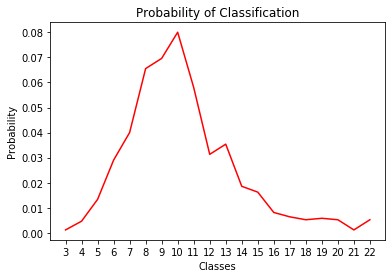

In [195]:
fig7, ax7 = plt.subplots(1,1)
ax7 = plt.plot(list(range(3,23)),vs/(vs.sum()+hs.sum()),'r')
plt.xticks([i for i in range(3,23,1)])
plt.title('Probability of Classification')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.savefig('Probability_of_Classification.png')
plt.show()